In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [2]:
# Some graph configurations
plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["font.size"] = 7
plt.rcParams["figure.dpi"] = 180
plt.rcParams['lines.linewidth'] = 1

In [15]:
# constants
G = 9.81   # using capital G as small g is reserved for functions below
m1 = m2 = 0.2
l1 = l2 = 0.25
lc1 = lc2 = 0.5


In [16]:
# computed constants
I1 = (m1 * lc1**2)/3
I2 = (m2 * lc2**2)/3

# The original nonlinear dynamics in State-Space form
$$
\dot{x}=\left[\begin{matrix}\dot{q}\\\ddot{q}\\\end{matrix}\right]=\left[\begin{matrix}\dot{q}\\-M\left(q\right)^{-1}\left(C\left(q,\dot{q}\right)\dot{q}+g\left(q\right)\right)\\\end{matrix}\right]+\left[\begin{matrix}0\\M\left(q\right)^{-1}\tau\\\end{matrix}\right]
$$
$$
M(q)=\left[\begin{matrix}m_1l_{c1}^2+m_2\left(l_1^2+l_{c2}^2+2l_1l_{c2}\cos{q_2}\right)+I_1+I_2&m_2\left(l_{c2}^2+l_1l_{c2}\cos{q_2}\right)+I_2\\m_2\left(l_{c2}^2+l_1l_{c2}\cos{q_2}\right)+I_2&m_2l_{c2}^2+I_2\\\end{matrix}\right]
$$
$$
C(q,\dot q) = \left[\begin{matrix}-m_2l_1l_{c2}\sin{\left(q_2\right)}\dot{q_2}&-m_2l_1l_{c2}\sin{\left(q_2\right)}\left(\dot{q_2}+\dot{q_1}\right)\\m_2l_1l_{c2}\sin{\left(q_2\right)}\dot{q_1}&0\\\end{matrix}\right]
$$
$$
g(q)=\left[\begin{matrix}\left(m_1l_{c1}+m_2l_1\right)g\cos{q_1}+m_2l_{c2}g\cos{\left(q_1+q_2\right)}\\\begin{matrix}m_2l_{c2}g\cos{\left(q_1+q_2\right)}\\\end{matrix}\\\end{matrix}\right]
$$
$$
I_i=\frac{m_i*l_{ci}^2}{3}
$$

In [17]:
# A lot of ugly `.reshape`s to avoid using the deprecated np.matrix
def M(q):
    _q1, q2 = q.reshape(-1)
    return np.array([
        [m1*lc1**2 + m2*(l1**2+lc2**2+2*l1*lc2*np.cos(q2))+ I1 + I2, m2*(lc2**2+l1*lc2*np.cos(q2))+I2],
        [         m2*(lc2**2 + l1*lc2*np.cos(q2)) + I2             ,          m2*lc2**2 + I2         ],
    ])
def C(q, q_dot):
    q = q.reshape(-1)
    q_dot = q_dot.reshape(-1)
    # q1 = q[0]
    q2 = q[1]
    q1_dot, q2_dot = q_dot
    return np.array([
        [-m2*l1*lc2*np.sin(q2)*q2_dot, -m2*l1*lc2*np.sin(q2)*(q2_dot+q1_dot)],
        [ m2*l1*lc2*np.sin(q2)*q1_dot,                  0                   ],
    ])
def g(q):
    q1, q2 = q.reshape(-1)
    return np.array([
        [(m1*lc1+m2*l1)*G*np.cos(q1) + m2*lc2*G*np.cos(q1+q2)],
        [                m2*lc2*G*np.cos(q1+q2)              ],
    ])

In [18]:
def x_dot(x, t, 𝜏=lambda x, t: np.array([0, 0])):
    q = x[:2].reshape((2,1))
    q_dot = x[2:].reshape((2,1))
    M_inv = np.linalg.inv(M(q))
    q_ddot = -M_inv@(C(q, q_dot)@q_dot + g(q)) + M_inv@𝜏(x, t).reshape((2,1))
    return np.array([*q_dot.reshape(-1), *q_ddot.reshape(-1)])

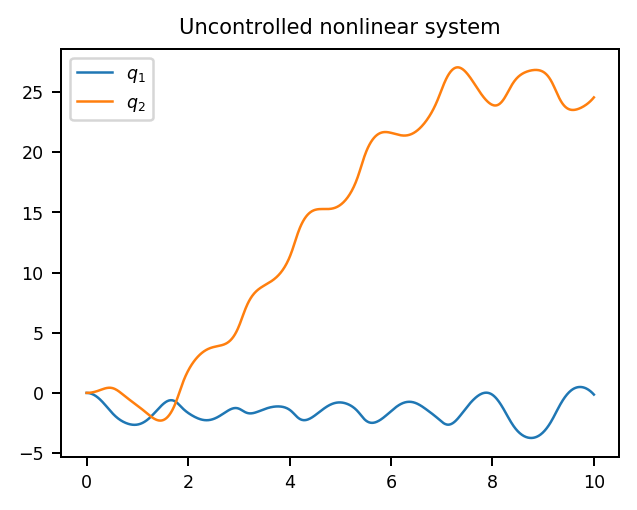

In [19]:
# Simulating it without any control
time = np.linspace(0, 10, 1000)
x_0 = np.array([0, 0, 0, 0])
solution = odeint(x_dot, x_0, time)
plt.plot(time, solution[:, :2])
plt.title("Uncontrolled nonlinear system")
plt.legend(['$q_1$', '$q_2$'])
plt.show()

# Controller
Design PD controller for each joint of the robot
$$
\tau=K_p\left(q^\ast-q\right)+K_d\left({\dot{q}}^\ast-\dot{q}\right)
$$
$$
q^\ast\left(t\right)=\left[\begin{matrix}\cos\left(t\right)&\cos{\left(t\right)}\\\end{matrix}\right]^T
$$

In [20]:
# PD controller coefficients
Kp = 200
Kd = 80

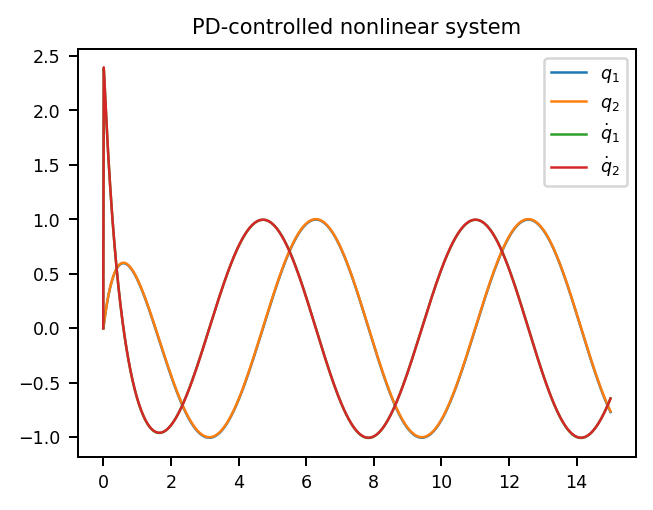

In [21]:
# Simulating it with PD control
time = np.linspace(0, 15, 1000)
x_0 = np.array([0, 0, 0, 0])
def q_desired(t):
    return np.array([np.cos(t), np.cos(t)])
def q_desired_dot(t):
    return np.array([-np.sin(t), -np.sin(t)])
def 𝜏(x, t):
    q = x[:2]
    q_dot = x[2:]
    return Kp*(q_desired(t) - q) + Kd*(q_desired_dot(t) - q_dot)

solution = odeint(x_dot, x_0, time, args=(𝜏,))
plt.plot(time, solution)
plt.title("PD-controlled nonlinear system")
plt.legend(['$q_1$', '$q_2$', '$\dot q_1$', '$\dot q_2$'])
plt.show()

# Parameter estimation
Using expression for $Y\left(q;\dot{q};\ddot{q}\right)$, estimate parameters $\pi$ by means least squares

$$
Y(q,\dot q,\ddot q)=\left[\matrix{\ddot {q}_1 & \cos(q_2)(2\ddot q_1+\ddot {q}_2)-\sin(q_2)(\dot{q}_1^2+2\dot{q}_1\dot{q}_2) & \ddot {q}_2 & g\cos(q_1) & g\cos(q_1+q_2)\\
0 & \cos(q_2)\ddot{q}_1+\sin(q_2)\dot{q}_1^2 & \ddot{q}_1+\ddot{q}_2 & 0 & g\cos(q_1+q_2)}\right]
$$
Least squares method:
$$ \tilde \pi = Y^\dagger \tau = (Y^T Y)^{-1} Y^T \tau $$

For reference, actual parameters should be
$$
\pi =\left[\matrix{m_1l_{c1}^2+m_2(l_1^2+l_{c2}^2) + I_1+I_2\\m_2l_1l_{c2}\\m_2l_{c2}^2+I_2\\m_1l_{c1}+m_2l_1\\m_2l_2}\right]
$$
The assignment assumes we don't know this

In [22]:
def Y(q, q_dot, q_ddot):
    q1, q2 = q.reshape(-1)
    q1_dot, q2_dot = q_dot.reshape(-1)
    q1_ddot, q2_ddot = q_ddot.reshape(-1)
    return np.array([
        [q_ddot[0], np.cos(q2)*(2*q1_ddot+q2_ddot)-np.sin(q2)*(q1_dot**2+2*q1_dot*q2_dot), q2_ddot, G*np.cos(q1), G*np.cos(q1+q2)],
        [    0    ,              np.cos(q2)*q1_ddot+np.sin(q2)*q1_dot**2              ,q1_ddot+q2_ddot,    0,     G*np.cos(q1+q2)],
    ])

# reference. actual parameters
π = np.array([
    [m1*lc2**2 + m2*(l1**2+lc2**2) + I1 + I2],
    [                m2*l1*lc2              ],
    [             m2*lc2**2 + I2            ],
    [             m1*lc1 + m2*l1            ],
    [                  m2*l2                ],
])
π

array([[0.14583333],
       [0.025     ],
       [0.06666667],
       [0.15      ],
       [0.05      ]])

In [23]:
qs = solution[:, :2]
q_dots = solution[:, 2:]
q_ddots = np.array([x_dot(np.array([*qs[i], *q_dots[i]]), time[i], 𝜏)[2:] for i in range(len(time))])

In [24]:
Ys = np.concatenate([Y(q, q_dot, q_ddot) for q, q_dot, q_ddot in zip(qs, q_dots, q_ddots)])

In [25]:
taus = np.concatenate([𝜏(x,t) for x, t in zip(solution, time)])

In [26]:
π_hat = np.linalg.pinv(Ys) @ taus.reshape((-1, 1))
π_hat

array([[0.14583311],
       [0.02499993],
       [0.06666665],
       [0.15000293],
       [0.09999943]])

In [28]:
sum([ x**2 for x in π_hat - π])

array([0.00249994])

# Adaptive Control
Assume that masses of each link slowly change according to the rule that you choose (different rule for each link). Design computed torque controller with feedforward adaptive term. For online parameter estimation use gradient descent. Show performance of the controller on two complex trajectories that you choose.